# Install Requirement

In [1]:
pip install transformers rouge-score torch scikit-learn nltk 


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a26a7d09ecefb1df815ef644379355a879be2ea55826fc64e9d5fad6fcb59bf5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 237 µs (started: 2024-08-14 23:29:00 +00:00)


# Import Library

In [3]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import BartTokenizer, BartForConditionalGeneration
from rouge_score import rouge_scorer
import gc
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re
import warnings
warnings.filterwarnings("ignore")

time: 6.3 s (started: 2024-08-14 23:29:01 +00:00)


# Data Preparation

In [4]:
csv_path = "/kaggle/input/dataset/dataset.csv"
text_column = "news_text"
summary_column = "manual_summary"

time: 422 µs (started: 2024-08-14 23:29:07 +00:00)


In [5]:
df = pd.read_csv(csv_path)

time: 103 ms (started: 2024-08-14 23:29:07 +00:00)


In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading punkt: HTTP Error 503: Request timedout
[nltk_data] Error loading stopwords: HTTP Error 503: Timed out while
[nltk_data]     waiting


False

time: 4min 4s (started: 2024-08-14 23:29:07 +00:00)


In [7]:
# Mengecek tipe data
print(df.dtypes)

# Mengecek missing value
print(df.isnull().sum())

category          object
news_text         object
manual_summary    object
Sentimen          object
auto_summary      object
dtype: object
category          0
news_text         0
manual_summary    0
Sentimen          0
auto_summary      0
dtype: int64
time: 6.3 ms (started: 2024-08-14 23:33:11 +00:00)


# EDA

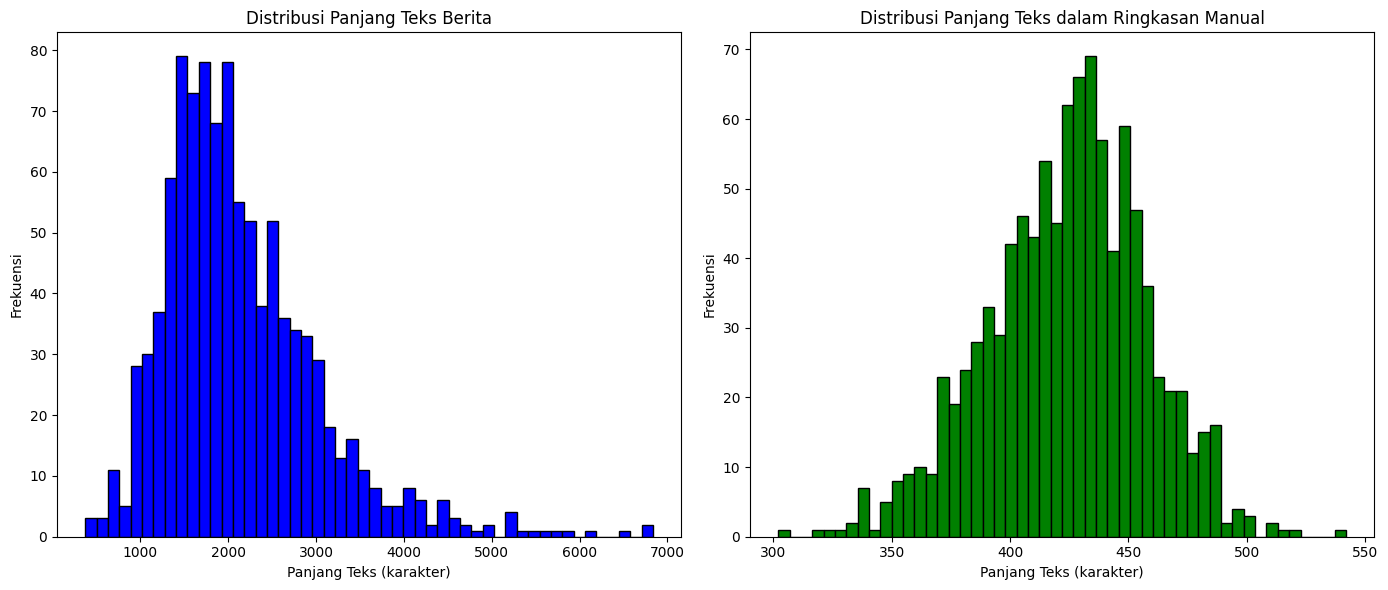

time: 780 ms (started: 2024-08-14 23:33:11 +00:00)


In [8]:
# Panjang Teks dalam Ringkasan Manual
df['summary_text_length'] = df['manual_summary'].apply(len)

# Panjang Teks dalam Teks Berita
df['text_length'] = df['news_text'].apply(len)

# Membuat plot
plt.figure(figsize=(14, 6))

# Plot kiri - Panjang Teks Berita
plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribusi Panjang Teks Berita')
plt.xlabel('Panjang Teks (karakter)')
plt.ylabel('Frekuensi')

# Plot kanan - Panjang Teks dalam Ringkasan Manual
plt.subplot(1, 2, 2)
plt.hist(df['summary_text_length'], bins=50, color='green', edgecolor='black')
plt.title('Distribusi Panjang Teks dalam Ringkasan Manual')
plt.xlabel('Panjang Teks (karakter)')
plt.ylabel('Frekuensi')

# Menampilkan plot
plt.tight_layout()
plt.show()

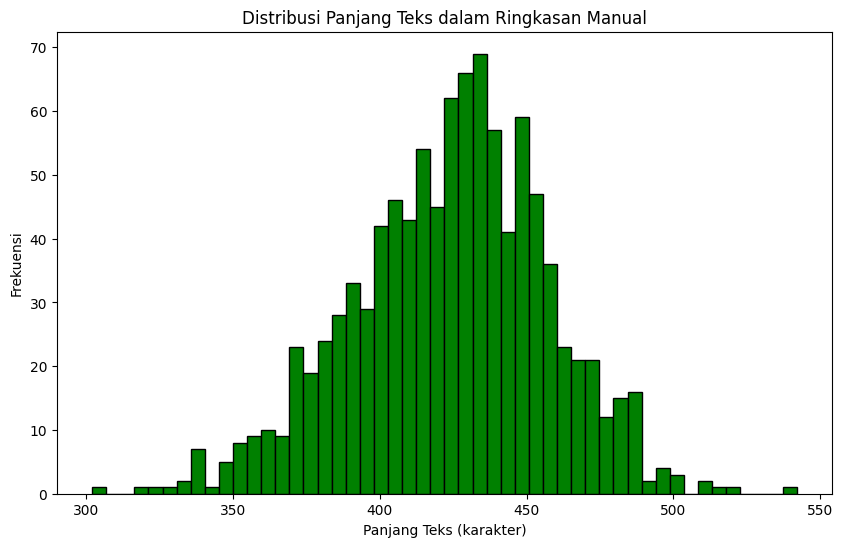

time: 347 ms (started: 2024-08-14 23:33:12 +00:00)


In [9]:
# Panjang Teks dalam Ringkasan Manual
df['summary_text_length'] = df['manual_summary'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df['summary_text_length'], bins=50, color='green', edgecolor='black')
plt.title('Distribusi Panjang Teks dalam Ringkasan Manual')
plt.xlabel('Panjang Teks (karakter)')
plt.ylabel('Frekuensi')
plt.show()

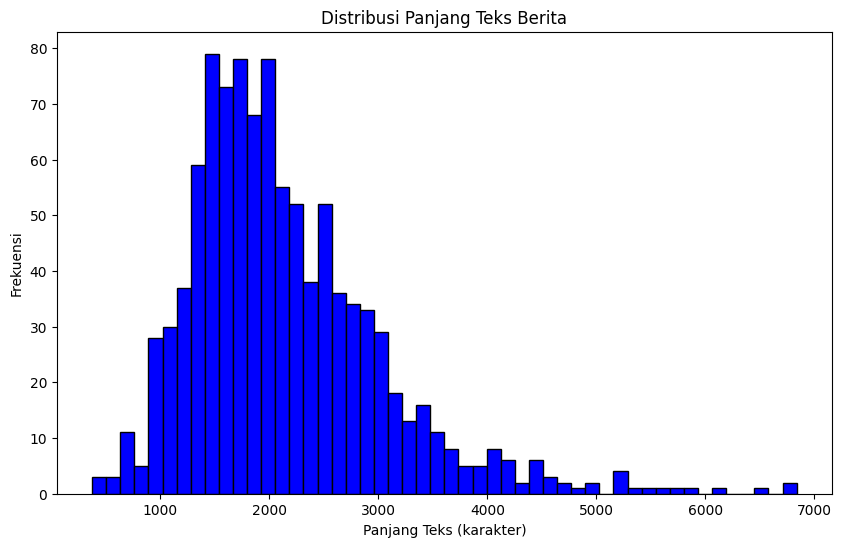

time: 514 ms (started: 2024-08-14 23:33:12 +00:00)


In [10]:
# Panjang Teks
df['text_length'] = df['news_text'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribusi Panjang Teks Berita')
plt.xlabel('Panjang Teks (karakter)')
plt.ylabel('Frekuensi')
plt.show()

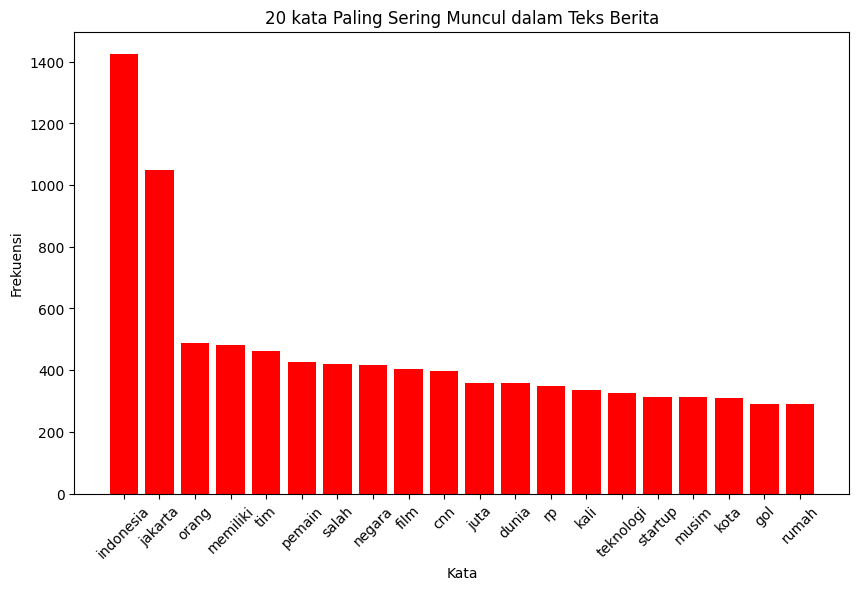

<Figure size 640x480 with 0 Axes>

time: 4.99 s (started: 2024-08-14 23:33:13 +00:00)


In [11]:
# Daftar stopwords bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Fungsi untuk menghapus tanda baca dan angka menggunakan regex
def remove_punctuation_and_numbers(text):
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus tanda baca
    text = re.sub(r'\d+', '', text)      # Menghapus angka
    return text

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
# Menghapus tanda baca, angka, dan stopwords dari news_text
df['news_text_clean'] = df['news_text'].apply(remove_punctuation_and_numbers).apply(remove_stopwords)

# Frekuensi Kata
all_words = ' '.join([text for text in df['news_text_clean']])
all_words = word_tokenize(all_words.lower())
word_freq = Counter(all_words)

# Frekuensi Unigram
unigrams = word_freq.most_common(20)
unigram_df = pd.DataFrame(unigrams, columns=['Kata', 'Frekuensi'])
plt.figure(figsize=(10, 6))
plt.bar(unigram_df['Kata'], unigram_df['Frekuensi'], color='red')
plt.title('20 kata Paling Sering Muncul dalam Teks Berita')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.show()
plt.savefig('/kaggle/working/contoh_gambar.png')
plt.show()

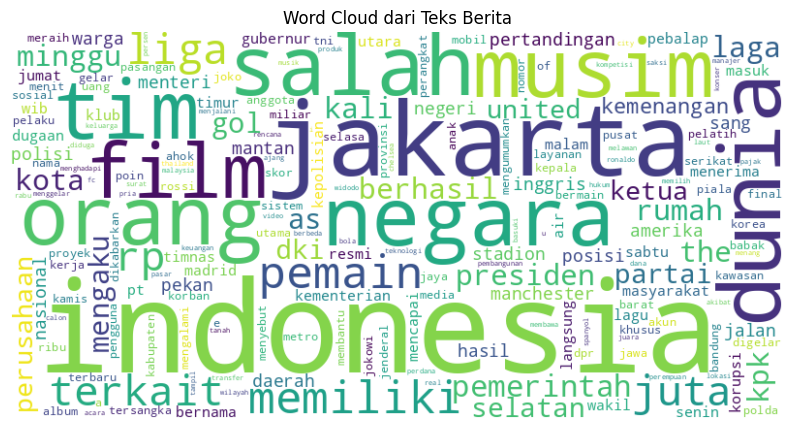

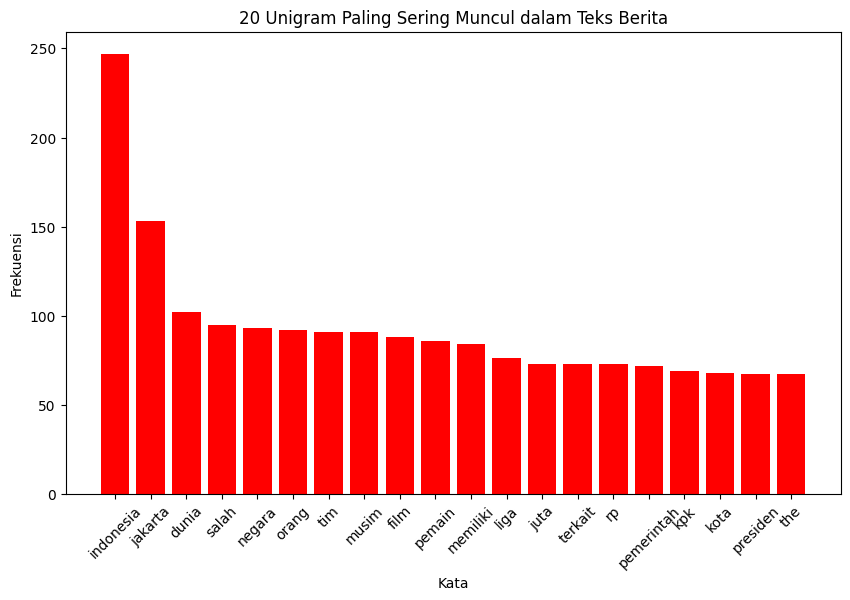

time: 2.46 s (started: 2024-08-14 23:33:18 +00:00)


In [12]:
# Daftar stopwords bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Fungsi untuk menghapus tanda baca dan angka menggunakan regex
def remove_punctuation_and_numbers(text):
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus tanda baca
    text = re.sub(r'\d+', '', text)      # Menghapus angka
    return text

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
# Menghapus tanda baca, angka, dan stopwords dari news_text
df['clean'] = df['manual_summary'].apply(remove_punctuation_and_numbers).apply(remove_stopwords)

# Frekuensi Kata
all_words = ' '.join([text for text in df['clean']])
all_words = word_tokenize(all_words.lower())
word_freq = Counter(all_words)

# Visualisasi Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Teks Berita')
plt.show()

# Frekuensi Unigram
unigrams = word_freq.most_common(20)
unigram_df = pd.DataFrame(unigrams, columns=['Kata', 'Frekuensi'])
plt.figure(figsize=(10, 6))
plt.bar(unigram_df['Kata'], unigram_df['Frekuensi'], color='red')
plt.title('20 Unigram Paling Sering Muncul dalam Teks Berita')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.show()

# Data Preprocessing

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

time: 24.8 ms (started: 2024-08-14 23:33:20 +00:00)


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)
config = BartForConditionalGeneration.from_pretrained(model_name)
model.to(device)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_l

time: 12.9 s (started: 2024-08-14 23:33:20 +00:00)


## Spliting Data

In [15]:
df = pd.read_csv("/kaggle/input/dataset/dataset.csv")

time: 37.5 ms (started: 2024-08-14 23:33:33 +00:00)


In [16]:
# Ambil 150 data secara acak untuk set pengujian
test_df = df.sample(n=150, random_state=42)

# Sisanya untuk set pelatihan dan validasi
remaining_data = df.drop(test_df.index)

# Bagi sisa data menjadi set pelatihan (80%) dan validasi (20%)
train_df, valid_df = train_test_split(remaining_data, test_size=0.2, random_state=42)

# Tampilkan hasil
print(f"Jumlah data test: {len(test_df)}")
print(f"Jumlah data train: {len(train_df)}")
print(f"Jumlah data validation: {len(valid_df)}")

Jumlah data test: 150
Jumlah data train: 680
Jumlah data validation: 170
time: 2.36 s (started: 2024-08-14 23:33:33 +00:00)


## Fungsi Peringkasan Teks

In [17]:
def summarize(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=1024, truncation=True, padding='max_length')
    inputs = {k: v.to(device) for k, v in inputs.items()}  
    summary_ids = model.generate(inputs['input_ids'], min_length=50, max_length=150)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

time: 68.5 ms (started: 2024-08-14 23:33:36 +00:00)


### Apply Fungsi

In [18]:
test_df['generated_summary'] = test_df['news_text'].apply(summarize)

time: 3min 7s (started: 2024-08-14 23:33:36 +00:00)


In [19]:
test_df = test_df.reset_index(drop=True)
test_df

,category,news_text,manual_summary,Sentimen,auto_summary,generated_summary
0,showbiz,Jakarta ( ANTARA News ) - Dua film nasional ...,"Dua film nasional yakni "" Surau dan Silek "" se...",positive,jakarta ( antara news ) - dua film nasional ya...,"Dua film nasional yakni "" Surau dan Silek "" se..."
1,showbiz,Gisella Anastasia akhirnya mengeluarkan single...,Gisella Anastasia akhirnya mengeluarkan single...,neutral,"setelah mengeluarkan single kedua, gisella ana...",Gisella Anastasia akhirnya mengeluarkan single...
2,tajuk utama,"Jakarta , CNN Indonesia - - Kepala Staf TNI An...",Kepala Staf TNI Angkatan Darat ( KSAD ) Jender...,neutral,menurut kepala staf tni angkatan darat ( ksad ...,Mulyono mengatakan tahun ini TNI AD tidak akan...
3,tajuk utama,Direktorat Reserse Narkoba Polda Metro Jaya me...,Direktorat Reserse Narkoba Polda Metro Jaya me...,neutral,direktorat reserse narkoba polda metro jaya me...,Direktorat Reserse Narkoba Polda Metro Jaya me...
4,showbiz,"Jakarta , CNN Indonesia - - Ibunda Selena Gome...","Ibunda Selena Gomez , Mandy Teefey , dilarikan...",negative,ibunda selena gomez dilarikan ke rumah sakit k...,"Ibunda Selena Gomez, Mandy Teefey, dilarikan k..."
...,...,...,...,...,...,...
145,tajuk utama,"Banda Aceh , ( ANTARA News ) - Jaksa dari Keja...",Kejaksaan Negeri Banda Aceh menangkap seorang ...,neutral,seorang terpidana korupsi yang masuk daftar pe...,Jaksa dari Kejaksaan Negeri Banda Aceh menangk...
146,teknologi,Platform blogging Medium kembali berbenah . Se...,Platform blogging Medium kembali berbenah . Se...,positive,setelah meluncurkan konten audio dan konten be...,Medium kini mencoba memperbaiki sistem ‘ penil...
147,teknologi,"Masih ingat dengan Astropad , aplikasi yang sa...",Perangkat tambahan bernama Luna Display bertug...,positive,"astro hq yang terbentuk dari astropad, aplikas...","Masih ingat dengan Astropad, aplikasi yang san..."
148,teknologi,Suara.com - Divisi riset dan pengembangan ( R&...,"Menurut Nikkei Asian Review , Divisi riset...",positive,honda dan saitec berencana meluncurkan baterai...,Honda dan lembaga penelitian Saitec berhasil m...


time: 15.1 ms (started: 2024-08-14 23:36:44 +00:00)


# Evaluasi ROUGE

In [20]:
def calculate_rouge(predictions, references):
    # Initialize the scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()

    # Compute scores for each prediction-reference pair
    for pred, ref in zip(predictions, references):
        scores = scorer.score(pred, ref)
        aggregator.add_scores(scores)
    
    # Aggregate the results
    result = aggregator.aggregate()
    
    # Extract and format the results
    rouge_scores = {}
    for key in result:
        rouge_scores[key] = {
            "precision": result[key].mid.precision,
            "recall": result[key].mid.recall,
            "f1": result[key].mid.fmeasure
        }
    return rouge_scores

time: 958 µs (started: 2024-08-14 23:36:44 +00:00)


In [21]:
from rouge_score import rouge_scorer, scoring
test_predictions = test_df['generated_summary']
test_references = test_df['manual_summary']
test_rouge_scores = calculate_rouge(test_predictions, test_references)
print("Test ROUGE scores:", test_rouge_scores)

Test ROUGE scores: {'rouge1': {'precision': 0.3987854332985953, 'recall': 0.6868593166678549, 'f1': 0.4981733421469572}, 'rouge2': {'precision': 0.3255342424341206, 'recall': 0.5696095213179426, 'f1': 0.4091538944029487}, 'rougeL': {'precision': 0.36624409338146924, 'recall': 0.632776929750825, 'f1': 0.4579875688514766}}
time: 789 ms (started: 2024-08-14 23:36:44 +00:00)


# Menghitung Score ROUGE Per Kolom

In [22]:
# predicted_summary = test_df['generated_summary'][4]
# reference_summary = test_df['manual_summary'][4]

time: 366 µs (started: 2024-08-14 23:36:45 +00:00)


In [23]:
# def lcs(X, Y):
#     m = len(X)
#     n = len(Y)
#     L = [[0] * (n+1) for i in range(m+1)]
    
#     # Membuat tabel LCS
#     for i in range(m+1):
#         for j in range(n+1):
#             if i == 0 or j == 0:
#                 L[i][j] = 0
#             elif X[i-1] == Y[j-1]:
#                 L[i][j] = L[i-1][j-1] + 1
#             else:
#                 L[i][j] = max(L[i-1][j], L[i][j-1])
    
#     # Membuat LCS dari tabel LCS
#     lcs_sequence = []
#     i, j = m, n
#     while i > 0 and j > 0:
#         if X[i-1] == Y[j-1]:
#             lcs_sequence.insert(0, X[i-1])
#             i -= 1
#             j -= 1
#         elif L[i-1][j] > L[i][j-1]:
#             i -= 1
#         else:
#             j -= 1
    
#     return L[m][n], lcs_sequence

# def tokenize_text(text):
#     return text.split()

# def calculate_rouge(predicted_summary, reference_summary):
#     # Tokenisasi ringkasan
#     predicted_tokens = tokenize_text(predicted_summary)
#     reference_tokens = tokenize_text(reference_summary)
    
#     # Menghitung jumlah token
#     predicted_length = len(predicted_tokens)
#     reference_length = len(reference_tokens)
    
#     # Menghitung LCS
#     lcs_length, lcs_sequence = lcs(predicted_tokens, reference_tokens)
    
#     # Menampilkan hasil
#     print(f"Predicted Tokens: {predicted_tokens}")
#     print(f"Reference Tokens: {reference_tokens}")
#     print(f"Predicted Length: {predicted_length}")
#     print(f"Reference Length: {reference_length}")
#     print(f"Longest Common Subsequence Length: {lcs_length}")
#     print(f"Longest Common Subsequence: {lcs_sequence}")

# # Contoh penggunaan
# calculate_rouge(predicted_summary, reference_summary)


time: 9.06 ms (started: 2024-08-14 23:36:45 +00:00)


In [24]:
# def count_ngrams(text, n):
#     words = text.split()
#     ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
#     return ngrams

# def get_ordered_common_ngrams(predicted_ngrams, reference_ngrams):
#     # Mengambil urutan dari n-gram yang umum (common) sesuai urutan kemunculannya
#     ordered_common_ngrams = [ngram for ngram in predicted_ngrams if ngram in reference_ngrams]
#     return ordered_common_ngrams

# def calculate_custom_rouge(predicted_summary, reference_summary):
#     # Menghitung unigram dan bigram
#     predicted_unigrams = count_ngrams(predicted_summary, 1)
#     reference_unigrams = count_ngrams(reference_summary, 1)
#     predicted_bigrams = count_ngrams(predicted_summary, 2)
#     reference_bigrams = count_ngrams(reference_summary, 2)
    
#     # Menghitung unigram yang cocok dan mengurutkan
#     ordered_common_unigrams = get_ordered_common_ngrams(predicted_unigrams, reference_unigrams)
    
#     # Menghitung bigram yang cocok dan mengurutkan
#     ordered_common_bigrams = get_ordered_common_ngrams(predicted_bigrams, reference_bigrams)
    
#     # Precision, Recall, dan F1-Score untuk ROUGE-1 (Unigram)
#     num_common_unigrams = len(ordered_common_unigrams)
#     precision_unigram = num_common_unigrams / len(predicted_unigrams) if len(predicted_unigrams) > 0 else 0
#     recall_unigram = num_common_unigrams / len(reference_unigrams) if len(reference_unigrams) > 0 else 0
#     f1_score_unigram = 2 * (precision_unigram * recall_unigram) / (precision_unigram + recall_unigram) if (precision_unigram + recall_unigram) > 0 else 0
    
#     # Precision, Recall, dan F1-Score untuk ROUGE-2 (Bigram)
#     num_common_bigrams = len(ordered_common_bigrams)
#     precision_bigram = num_common_bigrams / len(predicted_bigrams) if len(predicted_bigrams) > 0 else 0
#     recall_bigram = num_common_bigrams / len(reference_bigrams) if len(reference_bigrams) > 0 else 0
#     f1_score_bigram = 2 * (precision_bigram * recall_bigram) / (precision_bigram + recall_bigram) if (precision_bigram + recall_bigram) > 0 else 0
    
#     # Menampilkan hasil
#     print(f"ROUGE-1 -> Precision: {precision_unigram:.4f}, Recall: {recall_unigram:.4f}, F1-Score: {f1_score_unigram:.4f}")
#     print(f"ROUGE-2 -> Precision: {precision_bigram:.4f}, Recall: {recall_bigram:.4f}, F1-Score: {f1_score_bigram:.4f}")
    
#     # Tampilkan Unigram dan Bigram
#     print("\nUnigrams in Predicted Summary:")
#     print(predicted_unigrams)
#     print("\nUnigrams in Reference Summary:")
#     print(reference_unigrams)
#     print("\nCommon Unigrams in Order:")
#     print(ordered_common_unigrams)
    
#     print("\nBigrams in Predicted Summary:")
#     print(predicted_bigrams)
#     print("\nBigrams in Reference Summary:")
#     print(reference_bigrams)
#     print("\nCommon Bigrams in Order:")
#     print(ordered_common_bigrams)

# calculate_custom_rouge(predicted_summary, reference_summary)


time: 6.26 ms (started: 2024-08-14 23:36:45 +00:00)


In [25]:
# from rouge_score import rouge_scorer

# def count_ngrams(text, n):
#     words = text.split()
#     ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
#     return ngrams

# def lcs(X, Y):
#     m = len(X)
#     n = len(Y)
#     L = [[0] * (n+1) for i in range(m+1)]
    
#     for i in range(m+1):
#         for j in range(n+1):
#             if i == 0 or j == 0:
#                 L[i][j] = 0
#             elif X[i-1] == Y[j-1]:
#                 L[i][j] = L[i-1][j-1] + 1
#             else:
#                 L[i][j] = max(L[i-1][j], L[i][j-1])
    
#     return L[m][n]

# def calculate_rouge(predicted_summary, reference_summary):
#     # Inisialisasi ROUGE scorer
#     scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
#     # Hitung skor ROUGE
#     scores = scorer.score(reference_summary, predicted_summary)
    
#     # Tampilkan hasil ROUGE
#     for key, value in scores.items():
#         print(f"{key}: Precision: {value.precision:.4f}, Recall: {value.recall:.4f}, F1-Score: {value.fmeasure:.4f}")
    
#     # Hitung LCS
#     predicted_tokens = predicted_summary.split()
#     reference_tokens = reference_summary.split()
#     lcs_length = lcs(predicted_tokens, reference_tokens)
    
#     print(f"\nPredicted Tokens: {predicted_tokens}")
#     print(f"Reference Tokens: {reference_tokens}")
#     print(f"Longest Common Subsequence Length: {lcs_length}")
    
# # Contoh penggunaan (Anda bisa menyesuaikan 'predicted_summary' dan 'reference_summary' sesuai kebutuhan Anda)
# calculate_rouge(predicted_summary, reference_summary)

time: 8.71 ms (started: 2024-08-14 23:36:45 +00:00)


# Fungsi Tokenisasi Teks & Label 

In [26]:
df = df[['news_text','manual_summary']]

time: 10 ms (started: 2024-08-14 23:36:45 +00:00)


In [27]:
# Ambil 150 data secara acak untuk set pengujian
test_df = df.sample(n=150, random_state=42)

# Sisanya untuk set pelatihan dan validasi
remaining_data = df.drop(test_df.index)

# Bagi sisa data menjadi set pelatihan (80%) dan validasi (20%)
train_df, valid_df = train_test_split(remaining_data, test_size=0.2, random_state=42)

# Tampilkan hasil
print(f"Jumlah data test: {len(test_df)}")
print(f"Jumlah data train: {len(train_df)}")
print(f"Jumlah data validation: {len(valid_df)}")

Jumlah data test: 150
Jumlah data train: 680
Jumlah data validation: 170
time: 7.28 ms (started: 2024-08-14 23:36:45 +00:00)


In [28]:
# Tokenize the input data
def tokenize_function(examples):
    inputs = [doc for doc in examples['news_text']]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding="max_length")

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['manual_summary'], max_length=150, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

time: 1.27 ms (started: 2024-08-14 23:36:45 +00:00)


## Konversi Menjadi Dataset

In [29]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

time: 545 ms (started: 2024-08-14 23:36:45 +00:00)


In [38]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_valid_dataset = valid_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/680 [00:00<?, ? examples/s]

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

time: 14.1 s (started: 2024-08-15 00:34:38 +00:00)


In [31]:
# # Lihat struktur dari dataset yang telah ditokenisasi
# print(tokenized_train_dataset)

# # Lihat beberapa contoh data pertama yang telah ditokenisasi
# print(tokenized_train_dataset[0])

# # Lihat kolom yang tersedia di dataset yang telah ditokenisasi
# print(tokenized_train_dataset.column_names)


time: 421 µs (started: 2024-08-14 23:36:56 +00:00)


In [32]:
from transformers import Trainer, Seq2SeqTrainingArguments, EarlyStoppingCallback, TrainerCallback
import logging
            
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',  # Updated according to the warning
    save_strategy='epoch',  # Menyimpan model pada akhir setiap epoch
    save_total_limit=1,  # Menyimpan hanya satu model terbaik
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,  # Memuat model terbaik di akhir pelatihan
    metric_for_best_model="eval_loss",
    run_name='my_training_run'  # Specify a different run name if needed
)

# Callback untuk early stopping
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3  # Berhenti jika tidak ada peningkatan setelah 3 epoch
)


# Membuat Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_valid_dataset,
    tokenizer=tokenizer,
    callbacks=[early_stopping]  # Menambahkan callback untuk early stopping dan logging
)

# Menjalankan pelatihan
trainer.train()


2024-08-14 23:36:58.514245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 23:36:58.514356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 23:36:58.648871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.555600,0.439864
2,0.349500,0.385121
3,0.271900,0.402399
4,0.396600,0.376462
5,0.216800,0.409204
6,0.122700,0.422185
7,0.154400,0.447133


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

TrainOutput(global_step=1190, training_loss=0.33130131734519447, metrics={'train_runtime': 1775.8907, 'train_samples_per_second': 3.829, 'train_steps_per_second': 0.957, 'total_flos': 1.031541790605312e+16, 'train_loss': 0.33130131734519447, 'epoch': 7.0})

time: 29min 49s (started: 2024-08-14 23:36:56 +00:00)


### Menampilkan Best Epoch

In [33]:
# Mengecek epoch terbaik berdasarkan evaluasi loss
best_epoch = None
best_eval_loss = float('inf')

for log in trainer.state.log_history:
    if 'eval_loss' in log:
        if log['eval_loss'] < best_eval_loss:
            best_eval_loss = log['eval_loss']
            best_epoch = log['epoch']

# Menampilkan hasil epoch terbaik
print(f"Best epoch: {best_epoch}")
print(f"Best evaluation loss: {best_eval_loss}")

Best epoch: 4.0
Best evaluation loss: 0.3764618933200836
time: 2.4 ms (started: 2024-08-15 00:06:46 +00:00)


In [34]:
# import shutil
# import os

# # Menghapus direktori tertentu setelah pelatihan
# def clean_up_directories(directories):
#     for directory in directories:
#         if os.path.exists(directory):
#             shutil.rmtree(directory)
#             print(f"Deleted directory: {directory}")

# # Menjalankan fungsi clean_up_directories dengan daftar direktori yang ingin dihapus
# directories_to_delete = ['/kaggle/working/logs']
# clean_up_directories(directories_to_delete)

time: 7.13 s (started: 2024-08-15 00:06:46 +00:00)


In [35]:
import os

# Lihat direktori penyimpanan untuk menemukan checkpoint yang disimpan setelah epoch 4
checkpoint_dir = './results'
checkpoints = [os.path.join(checkpoint_dir, d) for d in os.listdir(checkpoint_dir) if os.path.isdir(os.path.join(checkpoint_dir, d))]
checkpoints.sort()
print("Available checkpoints:", checkpoints)


Available checkpoints: ['./results/checkpoint-680']
time: 3.73 ms (started: 2024-08-15 00:06:53 +00:00)


In [39]:
# best_checkpoint = checkpoints
best_checkpoint = './results/checkpoint-680'
model = BartForConditionalGeneration.from_pretrained(best_checkpoint)

# Evaluasi model dari checkpoint terbaik
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_valid_dataset,
    tokenizer=tokenizer
)

# Evaluasi model pada validation set
eval_results = trainer.evaluate()
print("Validation results from best checkpoint:", eval_results)

# Evaluasi model pada test set
test_results = trainer.evaluate(tokenized_test_dataset)
print("Test results from best checkpoint:", test_results)

Validation results from best checkpoint: {'eval_loss': 0.3764618933200836, 'eval_runtime': 14.6894, 'eval_samples_per_second': 11.573, 'eval_steps_per_second': 2.927}
Test results from best checkpoint: {'eval_loss': 0.49845460057258606, 'eval_runtime': 12.9546, 'eval_samples_per_second': 11.579, 'eval_steps_per_second': 2.933}
time: 29.8 s (started: 2024-08-15 00:35:20 +00:00)


## Menerapkan Model Fine-Tuning

In [40]:
from rouge_score import rouge_scorer, scoring
# Menerapkan fungsi ringkasan pada data uji dan validasi
test_df['tuned_summary'] = test_df['news_text'].apply(summarize)

time: 4min 42s (started: 2024-08-15 00:36:10 +00:00)


In [41]:
# Evaluasi kinerja model pada data uji dan validasi
test_predictions = test_df['tuned_summary'].tolist()
test_references = test_df['manual_summary'].tolist()
test_rouge_scores = calculate_rouge(test_predictions, test_references)
print("Test ROUGE scores:", test_rouge_scores)

Test ROUGE scores: {'rouge1': {'precision': 0.6298298043560361, 'recall': 0.6788715310494507, 'f1': 0.6492648665033727}, 'rouge2': {'precision': 0.5405327055240634, 'recall': 0.5848220085524028, 'f1': 0.557977379860108}, 'rougeL': {'precision': 0.5868279144165507, 'recall': 0.6331240458656514, 'f1': 0.6057389915859275}}
time: 986 ms (started: 2024-08-15 00:40:52 +00:00)


# Save Model

In [ ]:
# # Save model and tokenizer
# model.save_pretrained('./saved_model')
# tokenizer.save_pretrained('./saved_model')

In [ ]:
# model = BartForConditionalGeneration.from_pretrained(model_path)


# # Memindahkan model ke perangkat yang diinginkan
# model.to(device)


In [ ]:
# import pandas as pd
# from transformers import BartTokenizer, BartForConditionalGeneration, pipeline

# def load_model_and_tokenizer(model_path):
#     model = BartForConditionalGeneration.from_pretrained(model_path)
#     tokenizer = BartTokenizer.from_pretrained(model_path)
#     summarization_pipeline = pipeline('summarization', model=model, tokenizer=tokenizer)
#     return summarization_pipeline, tokenizer

# def summarize1(text, summarization_pipeline, device):
#     inputs = summarization_pipeline.tokenizer(text, return_tensors='pt', max_length=1024, truncation = True)
#     inputs = {k: v.to(device) for k, v in inputs.items()}  # Pindahkan input ke perangkat yang sesuai
#     summarization_pipeline.model.to(device)  # Pindahkan model ke perangkat yang sesuai
#     summary_ids = summarization_pipeline.model.generate(inputs['input_ids'],)
#     summary = summarization_pipeline.tokenizer.decode(summary_ids[0])
#     return summary

# def display_text_preview(text, max_length=50):
#     if len(text) > max_length:
#         return text[:max_length] + "..."
#     return text

# def main():
#     # Load the dataset
#     dataset_path = "/kaggle/input/dataset/pemilu.csv"
#     df1 = pd.read_csv(dataset_path)

#     # Load model and tokenizer
#     model_path = './saved_model'
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     summarization_pipeline, tokenizer = load_model_and_tokenizer(model_path)

#     # Ask the user to select rows for summarization
#     print("Pilih baris yang ingin diringkas:")
#     num_rows = len(df1)
#     for i in range(num_rows):
#         preview_text = display_text_preview(df1['text'].iloc[i])
#         print(f"{i+1}. {preview_text}")
    
#     row_choice = int(input("Masukkan nomor baris: "))
    
#     if row_choice < 1 or row_choice > num_rows:
#         print("Pilihan baris tidak valid.")
#         return

#     # Get the text and title from the selected row
#     text = df1['text'].iloc[row_choice - 1]
#     title = df1['title'].iloc[row_choice - 1]
#     print("\nTitle:")
#     print(title)
#     print("\nData asli:")
#     print(text)
    
#     # Summarize the selected text
#     summary = summarize1(text, summarization_pipeline, device)
#     print("\nRingkasan teks:")
#     print(summary)

# if __name__ == "__main__":
#     main()
